In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [ ]:
import pdb, sys, inspect
from enum import Enum

import pandas as pd
import torch

from transformers import *
from fastai2.text.all import *

In [ ]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


In [ ]:
MODEL_FOR_QUESTION_ANSWERING_MAPPING
MODEL_FOR_TOKEN_CLASSIFICATION_MAPPING
MODEL_MAPPING

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in MODEL_CONFIG_CLASSES), (),)
MODEL_CONFIG_CLASSES, MODEL_TYPES, #ALL_MODELS

([transformers.configuration_distilbert.DistilBertConfig,
  transformers.configuration_albert.AlbertConfig,
  transformers.configuration_roberta.RobertaConfig,
  transformers.configuration_bert.BertConfig,
  transformers.configuration_xlnet.XLNetConfig,
  transformers.configuration_flaubert.FlaubertConfig,
  transformers.configuration_xlm.XLMConfig],
 ('distilbert', 'albert', 'roberta', 'bert', 'xlnet', 'flaubert', 'xlm'))

## Utility Methods

In [ ]:
# converts string representation to class
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

## Class Inspection & Querying

**Notes**:

[1] There are "three standard classes required to use each model: **configuration, models and tokenizer**."

[2] All three standard classes can be initialized [via] `from_pretrained()`.  This method will download (as needed), cache, and load the pre-trained instace from the library or via the filesystem. 

**Models**: All derive from `nn.Module` (e.g., `BertModel`)

**Configuration**: Stores configuration required to **build a model** (e.g., `BertConfig`). "*If you are using a pretrained model* without any modification, *creating the model will automatically take care of instantiating the configuration* (which is part of the model)."

**Tokenizer**: Stores the vocab for each model and provides methods to encode/decode strings and provide the various embeddings required to be fed into a model.

**`from_pretrained()`**: To instantiate any of the above classes using a friendly name included in the library (`bert-base-uncased`) or from a path.

**`save_pretrained()`**: To save any of the classes locally so it can be re-loaded using `from_pretrained()`

In [ ]:
transformer_classes = inspect.getmembers(sys.modules[__name__], 
                                         lambda member: inspect.isclass(member)
                                                         and member.__module__.startswith('transformers.'))

transformer_classes[:5]

[('AdamW', transformers.optimization.AdamW),
 ('AdaptiveEmbedding', transformers.modeling_transfo_xl.AdaptiveEmbedding),
 ('AlbertConfig', transformers.configuration_albert.AlbertConfig),
 ('AlbertForMaskedLM', transformers.modeling_albert.AlbertForMaskedLM),
 ('AlbertForQuestionAnswering',
  transformers.modeling_albert.AlbertForQuestionAnswering)]

In [ ]:
df = pd.DataFrame(transformer_classes, columns=['class_name', 'class_location'])
df.head()

,class_name,class_location
0,AdamW,<class 'transformers.optimization.AdamW'>
1,AdaptiveEmbedding,<class 'transformers.modeling_transfo_xl.AdaptiveEmbedding'>
2,AlbertConfig,<class 'transformers.configuration_albert.AlbertConfig'>
3,AlbertForMaskedLM,<class 'transformers.modeling_albert.AlbertForMaskedLM'>
4,AlbertForQuestionAnswering,<class 'transformers.modeling_albert.AlbertForQuestionAnswering'>


In [ ]:
df['module'] = df.class_location.apply(lambda v: v.__module__); df.head()

,class_name,class_location,module
0,AdamW,<class 'transformers.optimization.AdamW'>,transformers.optimization
1,AdaptiveEmbedding,<class 'transformers.modeling_transfo_xl.AdaptiveEmbedding'>,transformers.modeling_transfo_xl
2,AlbertConfig,<class 'transformers.configuration_albert.AlbertConfig'>,transformers.configuration_albert
3,AlbertForMaskedLM,<class 'transformers.modeling_albert.AlbertForMaskedLM'>,transformers.modeling_albert
4,AlbertForQuestionAnswering,<class 'transformers.modeling_albert.AlbertForQuestionAnswering'>,transformers.modeling_albert


In [ ]:
df.drop(labels=['class_location'], axis=1, inplace=True)
df.head()

,class_name,module
0,AdamW,transformers.optimization
1,AdaptiveEmbedding,transformers.modeling_transfo_xl
2,AlbertConfig,transformers.configuration_albert
3,AlbertForMaskedLM,transformers.modeling_albert
4,AlbertForQuestionAnswering,transformers.modeling_albert


In [ ]:
module_parts_df = df.module.str.split(".", n = -1, expand = True) 

In [ ]:
for i in range(len(module_parts_df.columns)):
    df[f'module_part_{i}'] = module_parts_df[i]
    
df.head()

,class_name,module,module_part_0,module_part_1,module_part_2,module_part_3
0,AdamW,transformers.optimization,transformers,optimization,None,None
1,AdaptiveEmbedding,transformers.modeling_transfo_xl,transformers,modeling_transfo_xl,None,None
2,AlbertConfig,transformers.configuration_albert,transformers,configuration_albert,None,None
3,AlbertForMaskedLM,transformers.modeling_albert,transformers,modeling_albert,None,None
4,AlbertForQuestionAnswering,transformers.modeling_albert,transformers,modeling_albert,None,None


In [ ]:
module_part_1_df = df.module_part_1.str.split("_", n = 1, expand = True) 
module_part_1_df.head()

,0,1
0,optimization,None
1,modeling,transfo_xl
2,configuration,albert
3,modeling,albert
4,modeling,albert


In [ ]:
df[['functional_area', 'arch']] = module_part_1_df
df.head()

,class_name,module,module_part_0,module_part_1,module_part_2,module_part_3,functional_area,arch
0,AdamW,transformers.optimization,transformers,optimization,None,None,optimization,None
1,AdaptiveEmbedding,transformers.modeling_transfo_xl,transformers,modeling_transfo_xl,None,None,modeling,transfo_xl
2,AlbertConfig,transformers.configuration_albert,transformers,configuration_albert,None,None,configuration,albert
3,AlbertForMaskedLM,transformers.modeling_albert,transformers,modeling_albert,None,None,modeling,albert
4,AlbertForQuestionAnswering,transformers.modeling_albert,transformers,modeling_albert,None,None,modeling,albert


Look custom, task-based implementations of models (indicated by `<model>For<task>`)

In [ ]:
model_type_df = df[(df.functional_area == 'modeling')].class_name.str.split('For', n=1, expand=True)
model_type_df.head()

,0,1
1,AdaptiveEmbedding,None
3,Albert,MaskedLM
4,Albert,QuestionAnswering
5,Albert,SequenceClassification
6,Albert,TokenClassification


In [ ]:
model_type_df[1] = np.where(model_type_df[1].notnull(), 'For' + model_type_df[1].astype(str), model_type_df[1])
df['model_task'] = model_type_df[1]

Look custom, task-based implementations of models (indicated by `<model>With<task>`)

In [ ]:
model_type_df = df[(df.functional_area == 'modeling')].class_name.str.split('With', n=1, expand=True)
model_type_df.head()

,0,1
1,AdaptiveEmbedding,None
3,AlbertForMaskedLM,None
4,AlbertForQuestionAnswering,None
5,AlbertForSequenceClassification,None
6,AlbertForTokenClassification,None


In [ ]:
model_type_df[1] = np.where(model_type_df[1].notnull(), 
                            'With' + model_type_df[1].astype(str), 
                            df[(df.functional_area == 'modeling')].model_task)

df['model_task'] = model_type_df[1]

In [ ]:
df.head()

,class_name,module,module_part_0,module_part_1,module_part_2,module_part_3,functional_area,arch,model_task
0,AdamW,transformers.optimization,transformers,optimization,None,None,optimization,None,NaN
1,AdaptiveEmbedding,transformers.modeling_transfo_xl,transformers,modeling_transfo_xl,None,None,modeling,transfo_xl,None
2,AlbertConfig,transformers.configuration_albert,transformers,configuration_albert,None,None,configuration,albert,NaN
3,AlbertForMaskedLM,transformers.modeling_albert,transformers,modeling_albert,None,None,modeling,albert,ForMaskedLM
4,AlbertForQuestionAnswering,transformers.modeling_albert,transformers,modeling_albert,None,None,modeling,albert,ForQuestionAnswering


In [ ]:
print(list(df.model_task.unique()))
print(list(df.functional_area.unique()))
print(list(df.module_part_2.unique()))
print(list(df.module_part_3.unique()))

[nan, None, 'ForMaskedLM', 'ForQuestionAnswering', 'ForSequenceClassification', 'ForTokenClassification', 'ForPreTraining', 'WithLMHead', 'ForConditionalGeneration', 'ForMultipleChoice', 'ForNextSentencePrediction', 'ForQuestionAnsweringSimple', 'WithLMHeadModel', 'ForClassification']
['optimization', 'modeling', 'configuration', 'tokenization', 'pipelines', 'data', 'benchmark', 'hf', 'modelcard', 'training']
[None, 'processors']
[None, 'utils', 'squad']


In [ ]:
# look at what we're going to remove (use to verify we're just getting rid of stuff we want too)
# df[~df['hf_class_type'].isin(['modeling', 'configuration', 'tokenization'])]

In [ ]:
df = df[df['functional_area'].isin(['modeling', 'configuration', 'tokenization'])]

### Get included architectures

In [ ]:
def get_architectures(): 
    return df[(df.arch.notna()) & (df.arch != None)].arch.unique().tolist()

In [ ]:
print(get_architectures())

['transfo_xl', 'albert', 'auto', 'bart', 'bert', 'bert_japanese', 'ctrl', 'camembert', 'utils', 'distilbert', 'electra', 'flaubert', 'gpt2', 'mmbt', 'openai', 'encoder_decoder', 'roberta', 't5', 'xlm', 'xlm_roberta', 'xlnet']


In [ ]:
TRANSFORMER_ARCHITECTURES = Enum('TRANSFORMER_ARCHITECTURES', get_architectures())

In [ ]:
print(L(TRANSFORMER_ARCHITECTURES))

(#21) [<TRANSFORMER_ARCHITECTURES.transfo_xl: 1>,<TRANSFORMER_ARCHITECTURES.albert: 2>,<TRANSFORMER_ARCHITECTURES.auto: 3>,<TRANSFORMER_ARCHITECTURES.bart: 4>,<TRANSFORMER_ARCHITECTURES.bert: 5>,<TRANSFORMER_ARCHITECTURES.bert_japanese: 6>,<TRANSFORMER_ARCHITECTURES.ctrl: 7>,<TRANSFORMER_ARCHITECTURES.camembert: 8>,<TRANSFORMER_ARCHITECTURES.utils: 9>,<TRANSFORMER_ARCHITECTURES.distilbert: 10>...]


### Get an architecture's config

In [ ]:
def get_config(arch): 
    return df[(df.functional_area == 'configuration') & (df.arch == arch)].class_name.values[0]

In [ ]:
print(get_config('bert'))

BertConfig


### Get an architecture's tokenizers

There may be multiple so this returns a list

In [ ]:
def get_tokenizers(arch): 
    return df[(df.functional_area == 'tokenization') & (df.arch == arch)].class_name.values

In [ ]:
print(get_tokenizers('electra'))

['ElectraTokenizer' 'ElectraTokenizerFast']


### Get included custom model tasks

Get the type of tasks for which there is a custom model for (*optional: by architecture*). There are a number of customized models built for specific tasks like token classification, question/answering, LM, etc....

In [ ]:
def get_tasks(arch=None): 
    query = ['model_task.notna()']
    if (arch): query.append(f'arch == "{arch}"')
        
    return df.query(' & '.join(query)).model_task.unique().tolist()

In [ ]:
print(get_tasks())
print(get_tasks('bart'))

['ForMaskedLM', 'ForQuestionAnswering', 'ForSequenceClassification', 'ForTokenClassification', 'ForPreTraining', 'WithLMHead', 'ForConditionalGeneration', 'ForMultipleChoice', 'ForNextSentencePrediction', 'ForQuestionAnsweringSimple', 'WithLMHeadModel', 'ForClassification']
['ForConditionalGeneration', 'ForSequenceClassification']


In [ ]:
TRANSFORMER_TASKS_ALL = Enum('TRANSFORMER_TASKS_ALL', get_tasks())
TRANSFORMER_TASKS_AUTO = Enum('TRANSFORMER_TASKS_AUTO', get_tasks('auto'))

In [ ]:
print('--- all tasks ---')
print(L(TRANSFORMER_TASKS_ALL))
print('\n--- auto only ---')
print(L(TRANSFORMER_TASKS_AUTO))

--- all tasks ---
(#12) [<TRANSFORMER_TASKS_ALL.ForMaskedLM: 1>,<TRANSFORMER_TASKS_ALL.ForQuestionAnswering: 2>,<TRANSFORMER_TASKS_ALL.ForSequenceClassification: 3>,<TRANSFORMER_TASKS_ALL.ForTokenClassification: 4>,<TRANSFORMER_TASKS_ALL.ForPreTraining: 5>,<TRANSFORMER_TASKS_ALL.WithLMHead: 6>,<TRANSFORMER_TASKS_ALL.ForConditionalGeneration: 7>,<TRANSFORMER_TASKS_ALL.ForMultipleChoice: 8>,<TRANSFORMER_TASKS_ALL.ForNextSentencePrediction: 9>,<TRANSFORMER_TASKS_ALL.ForQuestionAnsweringSimple: 10>...]

--- auto only ---
(#5) [<TRANSFORMER_TASKS_AUTO.ForPreTraining: 1>,<TRANSFORMER_TASKS_AUTO.ForQuestionAnswering: 2>,<TRANSFORMER_TASKS_AUTO.ForSequenceClassification: 3>,<TRANSFORMER_TASKS_AUTO.ForTokenClassification: 4>,<TRANSFORMER_TASKS_AUTO.WithLMHead: 5>]


### Get included models

The transformer models available for use (*optional: by architecture | task*)

In [ ]:
def get_models(arch=None, task=None): 
    query = ['functional_area == "modeling"']
    if (arch): query.append(f'arch == "{arch}"')
    if (task): query.append(f'model_task == "{task}"')
        
    return df.query(' & '.join(query)).class_name.tolist()

In [ ]:
print(L(get_models()))

(#95) ['AdaptiveEmbedding','AlbertForMaskedLM','AlbertForQuestionAnswering','AlbertForSequenceClassification','AlbertForTokenClassification','AlbertModel','AlbertPreTrainedModel','AutoModel','AutoModelForPreTraining','AutoModelForQuestionAnswering'...]


In [ ]:
print(get_models(arch='bert'))

['BertForMaskedLM', 'BertForMultipleChoice', 'BertForNextSentencePrediction', 'BertForPreTraining', 'BertForQuestionAnswering', 'BertForSequenceClassification', 'BertForTokenClassification', 'BertModel', 'BertPreTrainedModel']


In [ ]:
print(get_models(task='ForTokenClassification'))

['AlbertForTokenClassification', 'AutoModelForTokenClassification', 'BertForTokenClassification', 'CamembertForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'RobertaForTokenClassification', 'XLMForTokenClassification', 'XLMRobertaForTokenClassification', 'XLNetForTokenClassification']


In [ ]:
print(get_models(arch='bert', task='ForTokenClassification'))

['BertForTokenClassification']


In [ ]:
TRANSFORMER_MODELS = Enum('TRANSFORMER_MODELS', get_models())

In [ ]:
print(L(TRANSFORMER_MODELS))

(#95) [<TRANSFORMER_MODELS.AdaptiveEmbedding: 1>,<TRANSFORMER_MODELS.AlbertForMaskedLM: 2>,<TRANSFORMER_MODELS.AlbertForQuestionAnswering: 3>,<TRANSFORMER_MODELS.AlbertForSequenceClassification: 4>,<TRANSFORMER_MODELS.AlbertForTokenClassification: 5>,<TRANSFORMER_MODELS.AlbertModel: 6>,<TRANSFORMER_MODELS.AlbertPreTrainedModel: 7>,<TRANSFORMER_MODELS.AutoModel: 8>,<TRANSFORMER_MODELS.AutoModelForPreTraining: 9>,<TRANSFORMER_MODELS.AutoModelForQuestionAnswering: 10>...]


### Get tokenizers, config, and model for a given model name / enum

In [ ]:
def get_classes_for_model(model_name_or_enum):
    model_name = model_name_or_enum if isinstance(model_name_or_enum, str) else model_name_or_enum.name
    
    meta = df[df.class_name == model_name]
    tokenizers = get_tokenizers(meta.arch.values[0])
    config = get_config(meta.arch.values[0])
    
    return ([str_to_class(tok) for tok in tokenizers], str_to_class(config), str_to_class(model_name))

In [ ]:
tokenizers, config, model = get_classes_for_model('RobertaForSequenceClassification')

print(tokenizers[0])
print(config)
print(model)

<class 'transformers.tokenization_roberta.RobertaTokenizer'>
<class 'transformers.configuration_roberta.RobertaConfig'>
<class 'transformers.modeling_roberta.RobertaForSequenceClassification'>


In [ ]:
tokenizers, config, model = get_classes_for_model(TRANSFORMER_MODELS.DistilBertModel)

print(tokenizers[0])
print(config)
print(model)

<class 'transformers.tokenization_distilbert.DistilBertTokenizer'>
<class 'transformers.configuration_distilbert.DistilBertConfig'>
<class 'transformers.modeling_distilbert.DistilBertModel'>


In [ ]:
def get_model_architecture(model_name_or_enum):
    model_name = model_name_or_enum if isinstance(model_name_or_enum, str) else model_name_or_enum.name
    return df[df.class_name == model_name].arch.values[0]

In [ ]:
get_model_architecture('RobertaForSequenceClassification')

'roberta'

## Loading Pre-Trained (configs, tokenizer, model)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

In [ ]:
def get_auto_hf_objects(pretrained_model_name_or_path,
                        task=TRANSFORMER_TASKS_AUTO.ForSequenceClassification, 
                        config=None):
    
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
    config = AutoConfig.from_pretrained(pretrained_model_name_or_path) if (config is None) else config
    
    model = str_to_class(f'AutoModel{task.name}').from_pretrained(pretrained_model_name_or_path, 
                                                                  config=config)
    arch = get_model_architecture(type(model).__name__)
    
    return (arch, tokenizer, config, model)

In [ ]:
arch, tokenizer, config, model = get_auto_hf_objects("bert-base-cased-finetuned-mrpc", 
                                                     task=TRANSFORMER_TASKS_AUTO.WithLMHead)

print(arch)
print(type(tokenizer))
print(type(config))
print(type(model))

bert
<class 'transformers.tokenization_bert.BertTokenizer'>
<class 'transformers.configuration_bert.BertConfig'>
<class 'transformers.modeling_bert.BertForMaskedLM'>


In [ ]:
arch, tokenizer, config, model = get_auto_hf_objects("fmikaelian/flaubert-base-uncased-squad", 
                                                              task=TRANSFORMER_TASKS_AUTO.ForQuestionAnswering)

print(arch)
print(type(tokenizer))
print(type(config))
print(type(model))

flaubert
<class 'transformers.tokenization_flaubert.FlaubertTokenizer'>
<class 'transformers.configuration_flaubert.FlaubertConfig'>
<class 'transformers.modeling_flaubert.FlaubertForQuestionAnsweringSimple'>


In [ ]:
def get_transformer_objects(pretrained_model_name_or_path, 
                            tokenizer_cls=BertTokenizer,
                            model_cls=TRANSFORMER_MODELS.BertModel,
                            config_cls=BertConfig):
    
    tokenizer = tokenizer_cls.from_pretrained(pretrained_model_name_or_path)
    
    if (config_cls is None):
        model = str_to_class(model_cls.name).from_pretrained(pretrained_model_name_or_path)
        config = None
    else:
        config = config_cls.from_pretrained(pretrained_model_name_or_path)
        model = str_to_class(model_cls.name).from_pretrained(pretrained_model_name_or_path, config=config)
    
    arch = get_model_architecture(type(model).__name__)
        
    return (arch, tokenizer, config, model)

In [ ]:
arch, tokenizer, config, model = get_transformer_objects("bert-base-cased-finetuned-mrpc",
                                                         tokenizer_cls=BertTokenizer, 
                                                         config_cls=None,
                                                         model_cls=TRANSFORMER_MODELS.BertForNextSentencePrediction)
print(arch)
print(type(tokenizer))
print(type(config))
print(type(model))

bert
<class 'transformers.tokenization_bert.BertTokenizer'>
<class 'NoneType'>
<class 'transformers.modeling_bert.BertForNextSentencePrediction'>


## TextTuple Block

In [ ]:
class HF_BaseInput(list): pass

In [ ]:
class HF_Tokenizer():
    def __init__(self, hf_arch, hf_tokenizer, **kwargs):
        self.hf_arch = hf_arch
        self.hf_tokenizer = hf_tokenizer
        
    def __call__(self, items): 
        for txt in items: yield self._tokenize(txt)

    def _tokenize(self, txt):
        return self.hf_tokenizer.tokenize(txt)

In [ ]:
class HF_BatchTransform(Transform):
    
    def __init__(self, hf_arch, hf_tokenizer, max_seq_len=512, truncation_strategy='longest_first'):
        
        self.hf_arch = hf_arch
        self.hf_tokenizer = hf_tokenizer
        store_attr(self, 'max_seq_len, truncation_strategy')
        
    def encodes(self, samples):
        
        encoded_samples = []
        for idx, sample in enumerate(samples):
            
            if (isinstance(sample[0], tuple)):
                a_tok_ids = sample[0][0].tolist()
                b_tok_ids = sample[0][1].tolist()
            else:
                a_tok_ids = sample[0].tolist()
                b_tok_ids = None
            
            res = self.hf_tokenizer.prepare_for_model(a_tok_ids, b_tok_ids, 
                                                      max_length=self.max_seq_len, 
                                                      pad_to_max_length=True,
                                                      truncation_strategy=self.truncation_strategy,
                                                      return_tensors='pt')
            
            input_ids = res['input_ids'][0]
            token_type_ids = res['token_type_ids'][0] if ('token_type_ids' in res) else torch.tensor([-9999]) 
            attention_mask = res['attention_mask'][0] if ('attention_mask' in res) else torch.tensor([-9999]) 

            inputs = [input_ids, token_type_ids, attention_mask]
            targets = sample[1:]
            
            encoded_samples.append((HF_BaseInput(inputs), *targets))
            
        return encoded_samples
    
    def decodes(self, encoded_samples):
        pdb.set_trace()
        pass

NameError: name 'Transform' is not defined

In [ ]:
class HF_TextBlock(TransformBlock):
    
    @delegates(Numericalize.__init__)
    def __init__(self, tok_tfms, hf_arch, hf_tokenizer, 
                 hf_batch_tfm=None, vocab=None, max_seq_len=512, **kwargs):

        if hf_batch_tfm is None:
            hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len,
                                             truncation_strategy='longest_first')
            
        return super().__init__(type_tfms=[*tok_tfms, Numericalize(vocab, **kwargs)],
                                dl_type=SortedDL, 
                                dls_kwargs={ 'before_batch': hf_batch_tfm })

    @classmethod
    @delegates(Tokenizer.from_df, keep=True)
    def from_df(cls, text_cols_lists, hf_arch, hf_tokenizer,
                res_col_names=None, vocab=None, 
                hf_batch_tfm=None, max_seq_len=512, **kwargs):
        
        # grab hf tokenizer class to do the actual tokenization (via tok_func) and its vocab
        tokenizer_cls = partial(HF_Tokenizer, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer)
        if (vocab is None): vocab = list(hf_tokenizer.get_vocab())

        # build the column name(s) returned after tokenization
        if (res_col_names is None): res_col_names = [ f'text{i}' for i in range(len(text_cols_lists)) ] 
    
        tok_tfms = [ Tokenizer.from_df(text_cols, 
                                       res_col_name=res_col_name, 
                                       tok_func=tokenizer_cls,
                                       rules=[], **kwargs) 
                    for text_cols, res_col_name in zip(text_cols_lists, res_col_names) ]
  
        return cls(tok_tfms, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, 
                   hf_batch_tfm=hf_batch_tfm, vocab=vocab, max_seq_len=max_seq_len)

Test it out

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')
imdb_df['text2'] = imdb_df['text']
# imdb_df.head()

In [ ]:
task = TRANSFORMER_TASKS_AUTO.ForSequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)
hf_arch, hf_tokenizer, hf_config, hf_model = get_auto_hf_objects(pretrained_model_name, 
                                                                 task=task, 
                                                                 config=config)

In [ ]:
# hft_config

In [ ]:
# tokenizer_cls = partial(HF_Tokenizer, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer)

In [ ]:
# vocab = list(hf_tokenizer.get_vocab())

In [ ]:
# # single input
# blocks = (
#     HF_TextBlock.from_df(text_cols_lists=[['text']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
#     CategoryBlock
# )

# dblock = DataBlock(blocks=blocks, 
#                    get_x=lambda x: x.text0,
#                    get_y=ColReader('label'), 
#                    splitter=ColSplitter(col='is_valid'))

In [ ]:
# tuple input (e.g. for question-answer, etc...)

# (optional): override HF_BatchTransform defaults
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=128, truncation_strategy='longest_first')

blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['text'],['text2']], 
                         hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, hf_batch_tfm=hf_batch_tfm),
    CategoryBlock
)

dblock = DataBlock(blocks=blocks, 
                   get_x=lambda x: (x.text0, x.text1),
                   get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
# dblock.summary(imdb_df)

In [ ]:
bsz = 4

In [ ]:
%%time
dls = dblock.dataloaders(imdb_df, bs=bsz)

CPU times: user 2.76 s, sys: 1.24 s, total: 4 s
Wall time: 4.73 s


In [ ]:
[y.item() for x,y in dls.train_ds ]
Counter([y.item() for x,y in dls.train_ds ])

Counter({0: 417, 1: 383})

In [ ]:
dls.items['label'].value_counts()

negative    417
positive    383
Name: label, dtype: int64

In [ ]:
b = dls.one_batch(); len(b), len(b[0]), len(b[1]) 

(2, 3, 4)

In [ ]:
b[0][0].shape, b[0][1].shape, b[0][2].shape, b[1].shape

(torch.Size([4, 128]),
 torch.Size([4, 1]),
 torch.Size([4, 128]),
 torch.Size([4]))

In [ ]:
@typedispatch
def show_batch(x:HF_BaseInput, y, samples, hf_tokenizer, ctxs=None, max_n=6, **kwargs):        
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp)),*s[1:]) for inp, s in zip(x[0], samples))
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)

    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
len(dls.train.vocab[1])

2

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer)

,text,category
0,"<s>Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been</s></s>Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been</s>",negative
1,"<s>What we have here is a damn good little nineties thriller that, while perhaps lacking in substance, still provides great entertainment throughout it's running time and overall does everything you could possibly want a film of this nature to do. I saw this film principally because it was directed by John Dahl - a highly underrated director</s></s>What we have here is a damn good little nineties thriller that, while perhaps lacking in substance, still provides great entertainment throughout it's running time and overall does everything you could possibly want a film of this nature to do. I saw this film principally because it was directed by John Dahl - a highly underrated director</s>",positive
2,"<s>The combination of reading the Novella and viewing this film has inspired my wife and I to new levels. Recently I was pondering a statement made by the artist Thomas Kinkade in one of his inspirational books; He states: ""You and I were not designed to breathe the fetid air of five</s></s>The combination of reading the Novella and viewing this film has inspired my wife and I to new levels. Recently I was pondering a statement made by the artist Thomas Kinkade in one of his inspirational books; He states: ""You and I were not designed to breathe the fetid air of five</s>",positive
3,"<s>I have to admit I've caught this one a few times on the USA Network. There's just something about the, well, sheer stupidity of this flick which makes me want to watch it whenever it's on. Yes, you're right about the sub-par acting, the plot which only an seven year</s></s>I have to admit I've caught this one a few times on the USA Network. There's just something about the, well, sheer stupidity of this flick which makes me want to watch it whenever it's on. Yes, you're right about the sub-par acting, the plot which only an seven year</s>",negative


In [ ]:
class HF_BaseModelWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        self.hf_model_fwd_args = hf_model.forward.__code__.co_varnames
        
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs[0]
    
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

In [ ]:
def hf_splitter(m):
    root_modules = list(m.hf_model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
model = HF_BaseModelWrapper(hf_model)

In [ ]:
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[MixedPrecision(clip=0.1)],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
# learn.summary()

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.033113110810518265)

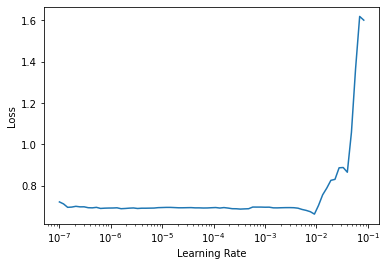

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.740570,0.660914,0.595000,00:07
1,0.688771,0.630932,0.650000,00:07
2,0.610525,0.609174,0.660000,00:07


In [ ]:
learn.predict('I really liked the movie')

('negative', tensor(0), tensor([0.5326, 0.4674]))

In [ ]:
inf_df = pd.DataFrame.from_dict([{'text0': 'I really liked the movie', 'text1': 'The movie was great'}], 
                                orient='columns')
learn.predict(inf_df.iloc[0])

('negative', tensor(0), tensor([0.5408, 0.4592]))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.494450,0.779669,0.755000,00:26
1,0.563251,0.947728,0.770000,00:25
2,0.401092,0.968394,0.775000,00:25


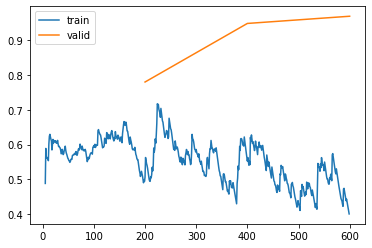

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.predict("This was a really good movie, ")

('positive', tensor(1), tensor([0.2022, 0.7978]))

In [ ]:
inf_df = pd.DataFrame.from_dict([{'text0': 'This was a really good movie', 'text1': 'i loved it'}], 
                                orient='columns')
learn.predict(inf_df.iloc[0])

('positive', tensor(1), tensor([0.4018, 0.5982]))

In [ ]:
learn.predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([9.9945e-01, 5.5145e-04]))

In [ ]:
inf_df = pd.DataFrame.from_dict([{'text0': 'Acting was so bad it was almost funny', 'text1': 'HATE!'}], 
                                orient='columns')
learn.predict(inf_df.iloc[0])

('negative', tensor(0), tensor([0.9980, 0.0020]))